# <font color=darkblue> SmartTweet Image</font>

#### <font color=black> Importations de base</font>

In [1]:
import csv
import json
import tweepy
import keras
import numpy as np
from tweepy import OAuthHandler
import tensorflow as tf
import tensorflow.keras as K

#pour executer sur le GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

Using TensorFlow backend.


## <font color=darkred> Création de la base de donnée</font>

#### <font color=black> La base de données a été constituée dans "SmartTweet Text" et les url des images des tweets se trouvent dans le champ 'url de l_image ' du document 'tweet2.csv'</font>

## <font color=darkred> Mise en forme des données</font>

#### <font color=black> Fonction qui vérifie si l'url existe</font>

In [2]:
# -*- coding: utf-8 -*-

import http.client
from urllib.parse import urlparse

def checkUrl(url):
    p = urlparse(url)
    conn = http.client.HTTPConnection(p.netloc)
    conn.request('HEAD', p.path)
    resp = conn.getresponse()
    return resp.status < 400

#### <font color=black> Télécharge les images correspondant aux tweets dans le dossier Images</font>

In [11]:
import sys
import urllib.request
from csv import reader
import os.path

csv_filename = sys.argv[1]

with open('tweet2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    i=0
    for row in reader:
        if row["url de l_image "]:
            url_image = row["url de l_image "]
            compte = row["Compte_twiter "]
            classe = row["classe "]
            if(checkUrl(url_image)==True):
                urllib.request.urlretrieve(url_image, "Images/" + compte + classe + str(i) + ".jpg")
        i+=1


#### <font color=black> Transformer jpg en matrice RGB</font>

In [5]:
import cv2 as cv

matrice = cv.imread("Images/DiorFashion229.jpg")   # charge le fichier dans une matrice de pixels couleur
print(matrice)

[[[118  93  73]
  [118  93  73]
  [117  93  73]
  ...
  [ 81  62  47]
  [ 80  61  46]
  [ 80  61  46]]

 [[118  93  73]
  [118  93  73]
  [117  93  73]
  ...
  [ 81  62  47]
  [ 80  61  46]
  [ 80  61  46]]

 [[118  93  73]
  [118  93  73]
  [117  93  73]
  ...
  [ 81  62  47]
  [ 80  61  46]
  [ 80  61  46]]

 ...

 [[156 133 107]
  [156 133 107]
  [156 132 108]
  ...
  [214 189 155]
  [214 189 155]
  [213 188 154]]

 [[157 134 108]
  [157 134 108]
  [157 133 109]
  ...
  [213 188 154]
  [213 188 154]
  [213 188 154]]

 [[157 134 108]
  [157 134 108]
  [157 133 109]
  ...
  [213 188 154]
  [213 188 154]
  [212 187 153]]]


#### <font color=black> Parcourir un fichier</font>

In [8]:
dirs = os.listdir( "Images/" )
i=0
for file in dirs:
    print("ok"+str(i))
    i+=1

ok0
ok1
ok2
ok3
ok4
ok5
ok6
ok7
ok8
ok9
ok10
ok11
ok12
ok13
ok14
ok15
ok16
ok17
ok18
ok19
ok20
ok21
ok22
ok23
ok24
ok25
ok26
ok27
ok28
ok29
ok30
ok31
ok32
ok33
ok34
ok35
ok36
ok37
ok38
ok39
ok40
ok41
ok42
ok43
ok44
ok45
ok46
ok47
ok48
ok49
ok50
ok51
ok52
ok53
ok54
ok55
ok56
ok57
ok58
ok59
ok60
ok61
ok62
ok63
ok64
ok65
ok66
ok67
ok68
ok69
ok70
ok71
ok72
ok73
ok74
ok75
ok76
ok77
ok78
ok79
ok80
ok81
ok82
ok83
ok84
ok85
ok86
ok87
ok88
ok89
ok90
ok91
ok92
ok93
ok94
ok95
ok96
ok97
ok98
ok99
ok100
ok101
ok102
ok103
ok104
ok105
ok106
ok107
ok108
ok109
ok110
ok111
ok112
ok113
ok114
ok115
ok116
ok117
ok118
ok119
ok120
ok121
ok122
ok123
ok124
ok125
ok126
ok127
ok128
ok129
ok130
ok131
ok132
ok133
ok134
ok135
ok136
ok137
ok138
ok139
ok140
ok141
ok142
ok143
ok144
ok145
ok146
ok147
ok148
ok149
ok150
ok151
ok152
ok153
ok154
ok155
ok156
ok157
ok158
ok159
ok160
ok161
ok162
ok163
ok164
ok165
ok166
ok167
ok168
ok169
ok170
ok171
ok172
ok173
ok174
ok175
ok176
ok177
ok178
ok179
ok180
ok181
ok182
ok183
ok184


#### <font color=black> Fonction qui renvoie y</font>

In [3]:
def Label(jpg):
    ListLabel=['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
    y=[0]*10
    for i in range(0,10):
        if(jpg.find(ListLabel[i])!=-1):
            y[i]=1
    return y

In [18]:
print(Label("Images/DiorFashion229.jpg"))
print(Label("AllBlacksSport5494.jpg"))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


#### <font color=black> Générateur de la base de données d'entrainement et de validation</font>

In [4]:
from PIL import Image

In [5]:
def train_gen():
    dirs = os.listdir( "Images/" )
    i=0
    for file in dirs:
        if(i%5!=0):
            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
            target = Label(file)
            yield image, target
        i+=1

def val_gen():
    dirs = os.listdir( "Images/" )
    i=0
    for file in dirs:
        if(i%5==0):
            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
            target = Label(file)
            yield image, target
        i+=1

In [6]:
ds_train = tf.data.Dataset.from_generator(
    train_gen,
    output_types =(tf.float32, tf.float32),
).shuffle(
    200
).padded_batch(
    32,
    padded_shapes=([224, 224, 3], [10])
).prefetch(10)


ds_val = tf.data.Dataset.from_generator(
    val_gen,
    output_types =(tf.float32, tf.float32),
).padded_batch(
    32,
    padded_shapes=([224, 224, 3], [10])
).prefetch(10)

In [32]:
next(iter(ds_train))

(<tf.Tensor: id=344475, shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.84313726, 0.8392157 , 0.8235294 ],
          [0.8392157 , 0.8352941 , 0.81960785],
          [0.81960785, 0.8156863 , 0.8       ],
          ...,
          [0.88235295, 0.8784314 , 0.87058824],
          [0.88235295, 0.8784314 , 0.87058824],
          [0.88235295, 0.8784314 , 0.87058824]],
 
         [[0.84313726, 0.8392157 , 0.8235294 ],
          [0.8392157 , 0.8352941 , 0.81960785],
          [0.81960785, 0.8156863 , 0.8       ],
          ...,
          [0.88235295, 0.8784314 , 0.87058824],
          [0.88235295, 0.8784314 , 0.87058824],
          [0.88235295, 0.8784314 , 0.87058824]],
 
         [[0.84313726, 0.8392157 , 0.8235294 ],
          [0.8392157 , 0.8352941 , 0.81960785],
          [0.8235294 , 0.81960785, 0.8039216 ],
          ...,
          [0.8784314 , 0.8745098 , 0.8666667 ],
          [0.8784314 , 0.8745098 , 0.8666667 ],
          [0.8784314 , 0.8745098 , 0.8666667 ]],
 
         ..

## <font color=darkred> Ecriture du réseau de classification des images</font>

#### <font color=black> Importations</font>

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dropout, Dense, GlobalAveragePooling3D
from tensorflow.keras.models import Model

#### <font color=black> Couches du model de classification des images</font>

In [22]:
def get_model():
    image_input = tf.keras.Input(shape=(224, 224, 3))
    image_trunk = tf.keras.applications.VGG16(input_tensor=image_input, input_shape =(224, 224, 3),
        pooling     =None,
        include_top =False,
        weights     ='imagenet',
        layers      =K.layers
    )
 
#--- freeze ---#
    image_trunk.trainable = False
    
    x = image_trunk.output
    x = Conv2D(3, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    topic_pred = Dense(units = 10, activation = 'softmax', name='topic' )(x)
    model = Model(image_input, outputs=topic_pred, name='fully_conv_batchnorm')
    return model

def get_compiled_model():
    model = get_model()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

model_I =get_compiled_model()
model_I.summary()
    
 

Model: "fully_conv_batchnorm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 12

#### <font color=black> Entrainement de réseau d'image</font>

In [8]:
batch_size = 128
epochs = 50

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=5, restore_best_weights=True)
history = model_I.fit(ds_train, batch_size=None, epochs=epochs, callbacks=[earlyStopping], verbose=1, validation_data=ds_val)
score = model_I.evaluate(ds_train, verbose=0)

Epoch 1/50
     68/Unknown - 43s 631ms/step - loss: 2.2373 - acc: 0.1838

/space/homes/smarttweet/smarttweet/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


223/223 [==============================] - 158s 709ms/step - loss: 2.1253 - acc: 0.2568 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/50
223/223 [==============================] - 157s 703ms/step - loss: 1.9384 - acc: 0.3597 - val_loss: 1.8923 - val_acc: 0.3774
Epoch 3/50
223/223 [==============================] - 156s 700ms/step - loss: 1.8434 - acc: 0.3946 - val_loss: 1.8281 - val_acc: 0.3993
Epoch 4/50
223/223 [==============================] - 157s 704ms/step - loss: 1.7811 - acc: 0.4191 - val_loss: 1.7851 - val_acc: 0.4123
Epoch 5/50
223/223 [==============================] - 190s 852ms/step - loss: 1.7368 - acc: 0.4287 - val_loss: 1.7586 - val_acc: 0.4213
Epoch 6/50
223/223 [==============================] - 190s 850ms/step - loss: 1.7008 - acc: 0.4413 - val_loss: 1.7293 - val_acc: 0.4286
Epoch 7/50
223/223 [==============================] - 189s 848ms/step - loss: 1.6729 - acc: 0.4486 - val_loss: 1.7089 - val_acc: 0.4359
Epoch 8/50
223/223 [==============================]

#### <font color=black> Courbe des loss</font>

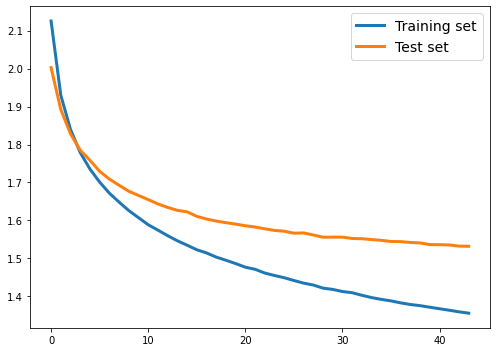

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()

#### <font color=black> Courbe des accuracy</font>

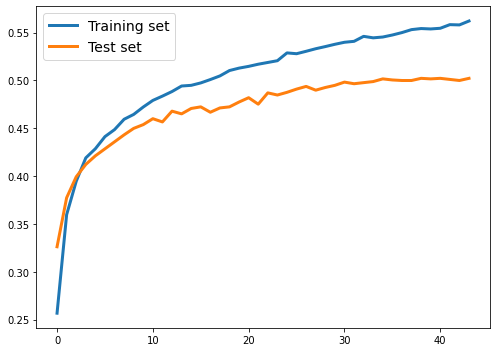

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()

## <font color=darkred> Obtension des résultats par catégorie</font>

#### <font color=black> Création des fonctions qui indiquent la précision, le rappel et le score_F1</font>

In [9]:
labels = ['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']

class LabelWisePrecision(K.metrics.CategoricalAccuracy):
    def __init__(self, class_id, **kwargs):
        if 'name' not in kwargs:
            kwargs['name'] = f'{labels[class_id]}_P'
        super().__init__(**kwargs)
        
        self.class_id = class_id
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.cast(tf.argmax(y_pred, axis=1) == self.class_id, tf.float32)
        if sample_weight is None:
            sample_weight = mask
        else:
            sample_weight *= mask
        super().update_state(y_true, y_pred, sample_weight=sample_weight)

class LabelWiseRecall(K.metrics.CategoricalAccuracy):
    def __init__(self, class_id, **kwargs):
        if 'name' not in kwargs:
            kwargs['name'] = f'{labels[class_id]}_R'
        super().__init__(**kwargs)
        
        self.class_id = class_id
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.cast(tf.argmax(y_true, axis=1) == self.class_id, tf.float32)
        if sample_weight is None:
            sample_weight = mask
        else:
            sample_weight *= mask
        super().update_state(y_true, y_pred, sample_weight=sample_weight)
        
        
class LabelWiseF1(K.metrics.Metric):
    """Needs already instantiated precision and recall"""
    def __init__(self, label_wise_p, label_wise_r, **kwargs):
        assert label_wise_p.class_id == label_wise_r.class_id
        self.class_id = label_wise_p.class_id
        if 'name' not in kwargs:
            kwargs['name'] = f'{labels[self.class_id]}_F1'
        super().__init__(**kwargs)
        self.precision = label_wise_p
        self.recall    = label_wise_r
    def reset_states(self):
        pass
    def update_state(self, y_true, y_pred, sample_weight=None):
        pass
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        f1 = tf.math.divide_no_nan(2 * p * r, p + r)
        return f1

    
# on instancie les précisions et rappels pour chaque labels
precisions = [LabelWisePrecision(class_id=l) for l, _ in enumerate(labels)]
recalls    = [LabelWiseRecall   (class_id=l) for l, _ in enumerate(labels)]
# on instancie les F1 à partir de ces derniers
F1s = [LabelWiseF1(p, r) for p, r in zip(precisions, recalls)]


#### <font color=black> Modèle de classification des images précédent légèrement modifié pour qu'il affiche la précision, le rappel et le score_F1 par catégorie </font>

In [10]:
def get_model():
    image_input = tf.keras.Input(shape=(224, 224, 3))
    image_trunk = tf.keras.applications.VGG16(input_tensor=image_input, input_shape =(224, 224, 3),
        pooling     =None,
        include_top =False,
        weights     ='imagenet',
        layers      =K.layers
    )
 
#--- freeze ---#
    image_trunk.trainable = False
    
    x = image_trunk.output
    x = Conv2D(3, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    topic_pred = Dense(units = 10, activation = 'softmax', name='topic' )(x)
    model = Model(image_input, outputs=topic_pred, name='fully_conv_batchnorm')
    return model

def get_compiled_model():
    model = get_model()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'] + F1s + precisions + recalls)

    return model

model_I_Cat =get_compiled_model()
model_I_Cat.summary()
    
 

Model: "fully_conv_batchnorm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 12

#### <font color=black> Entrainement du modèle </font>

In [11]:
batch_size = 128
epochs = 70

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=10, restore_best_weights=True)
history = model_I_Cat.fit(ds_train, batch_size=None, epochs=epochs, callbacks=[earlyStopping], verbose=1, validation_data=ds_val)
score = model_I_Cat.evaluate(ds_train, verbose=0)

Epoch 1/70
     68/Unknown - 67s 987ms/step - loss: 2.2794 - categorical_accuracy: 0.1535 - Fashion_F1: 0.1472 - Health_F1: 0.0000e+00 - Tech_F1: 0.0000e+00 - Sport_F1: 0.2505 - Cooking_F1: 0.2518 - Music_F1: 0.0327 - Videogames_F1: 0.0000e+00 - Politic_F1: 0.0000e+00 - Science_F1: 0.0000e+00 - Cinema_F1: 0.0000e+00 - Fashion_P: 0.1436 - Health_P: 0.0000e+00 - Tech_P: 0.0000e+00 - Sport_P: 0.1581 - Cooking_P: 0.1615 - Music_P: 0.0625 - Videogames_P: 0.0000e+00 - Politic_P: 0.0000e+00 - Science_P: 0.0000e+00 - Cinema_P: 0.0000e+00 - Fashion_R: 0.1532 - Health_R: 0.0000e+00 - Tech_R: 0.0000e+00 - Sport_R: 0.6133 - Cooking_R: 0.5562 - Music_R: 0.0219 - Videogames_R: 0.0000e+00 - Politic_R: 0.0000e+00 - Science_R: 0.0000e+00 - Cinema_R: 0.0000e+00

/space/homes/smarttweet/smarttweet/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


223/223 [==============================] - 228s 1s/step - loss: 2.2160 - categorical_accuracy: 0.1860 - Fashion_F1: 0.2104 - Health_F1: 0.0000e+00 - Tech_F1: 0.0000e+00 - Sport_F1: 0.2802 - Cooking_F1: 0.3457 - Music_F1: 0.0111 - Videogames_F1: 0.0191 - Politic_F1: 0.0000e+00 - Science_F1: 0.0000e+00 - Cinema_F1: 0.0000e+00 - Fashion_P: 0.1958 - Health_P: 0.0000e+00 - Tech_P: 0.0000e+00 - Sport_P: 0.1699 - Cooking_P: 0.2641 - Music_P: 0.0526 - Videogames_P: 0.1081 - Politic_P: 0.0000e+00 - Science_P: 0.0000e+00 - Cinema_P: 0.0000e+00 - Fashion_R: 0.2269 - Health_R: 0.0000e+00 - Tech_R: 0.0000e+00 - Sport_R: 0.8068 - Cooking_R: 0.4990 - Music_R: 0.0062 - Videogames_R: 0.0105 - Politic_R: 0.0000e+00 - Science_R: 0.0000e+00 - Cinema_R: 0.0000e+00 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_Fashion_F1: 0.0000e+00 - val_Health_F1: 0.0000e+00 - val_Tech_F1: 0.0000e+00 - val_Sport_F1: 0.0000e+00 - val_Cooking_F1: 0.0000e+00 - val_Music_F1: 0.0000e+00 - val_Videogames_F

#### <font color=black> Courbe montrant l'evolution des différents paramètres au cours des époques par catégorie </font>

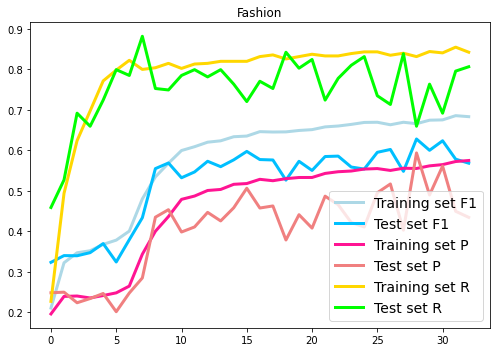

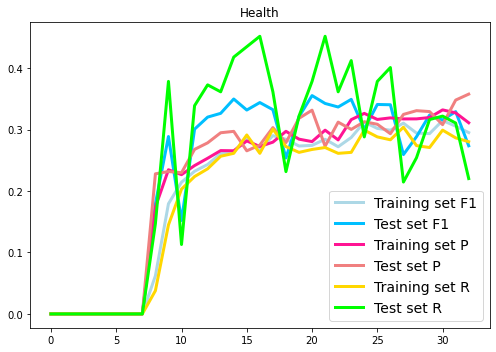

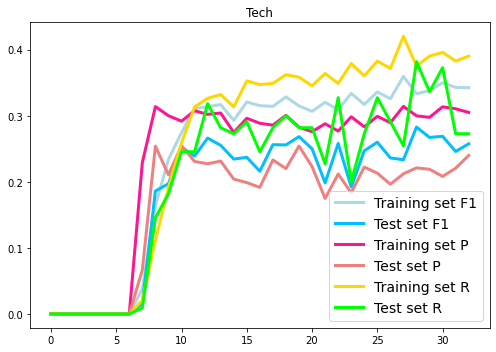

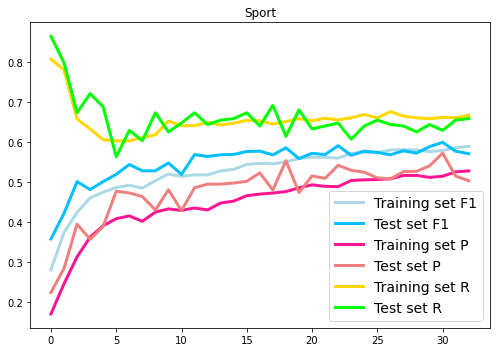

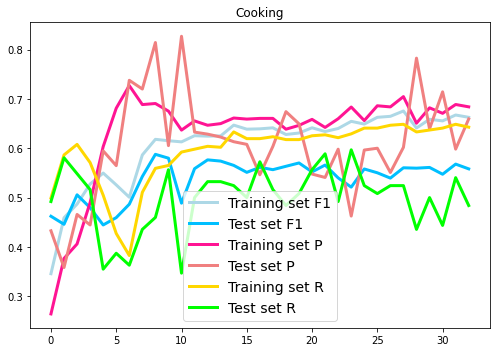

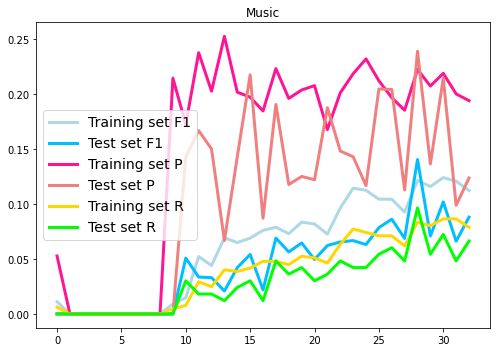

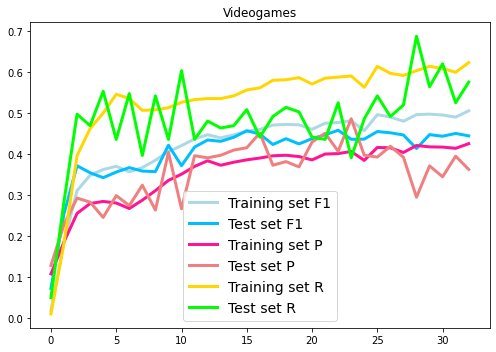

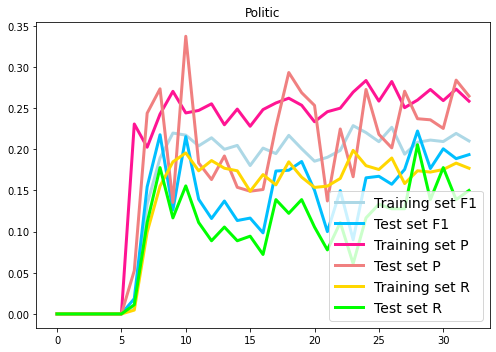

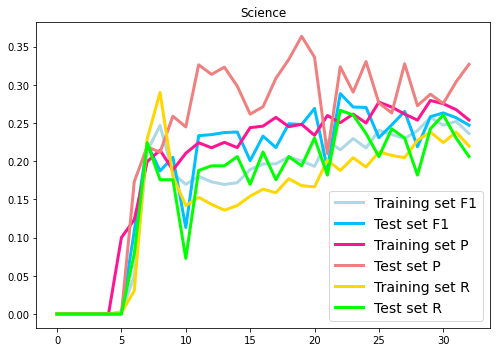

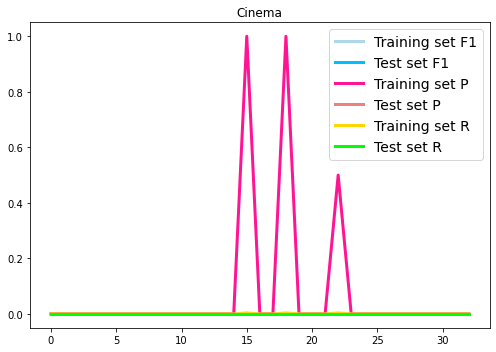

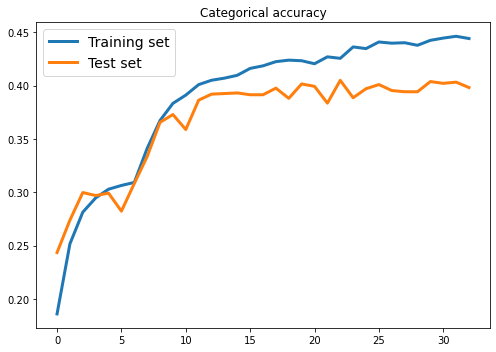

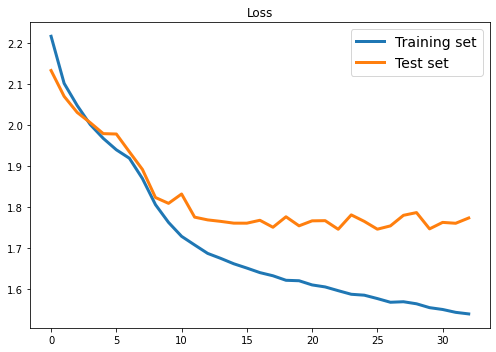

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Fashion_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Fashion_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Fashion_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Fashion_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Fashion_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Fashion_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Fashion')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Health_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Health_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Health_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Health_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Health_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Health_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Health')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Tech_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Tech_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Tech_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Tech_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Tech_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Tech_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Tech')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Sport_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Sport_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Sport_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Sport_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Sport_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Sport_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Sport')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Cooking_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Cooking_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Cooking_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Cooking_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Cooking_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Cooking_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Cooking')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Music_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Music_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Music_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Music_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Music_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Music_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Music')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Videogames_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Videogames_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Videogames_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Videogames_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Videogames_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Videogames_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Videogames')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Politic_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Politic_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Politic_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Politic_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Politic_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Politic_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Politic')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Science_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Science_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Science_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Science_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Science_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Science_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Science')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['Cinema_F1'], lw=3, label='Training set F1', c='lightblue')
plt.plot(history.epoch, history.history['val_Cinema_F1'], lw=3, label='Test set F1', c='deepskyblue')
plt.plot(history.epoch, history.history['Cinema_P'], lw=3, label='Training set P', c='deeppink')
plt.plot(history.epoch, history.history['val_Cinema_P'], lw=3, label='Test set P', c='lightcoral')
plt.plot(history.epoch, history.history['Cinema_R'], lw=3, label='Training set R', c='gold')
plt.plot(history.epoch, history.history['val_Cinema_R'], lw=3, label='Test set R', c='lime')
plt.legend(fontsize=14)
plt.title('Cinema')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['categorical_accuracy'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_categorical_accuracy'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Categorical accuracy')
plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss')
plt.tight_layout()

#### <font color=black> Comparaison des valeurs de précision, rappel et score_F1 en fonction de la catégorie lors de la dernière époque effectuée sur le jeu d'entrainement</font>

Text(0.5, 1.0, 'Training set')

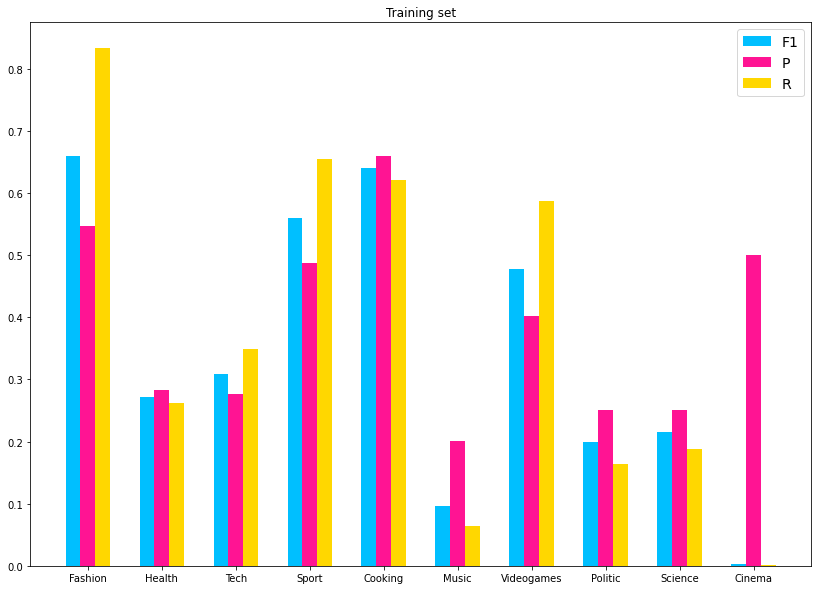

In [14]:
e=len(history.epoch)-11
labels = ['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
barWidth = 0.2
F1=[history.history['Fashion_F1'][e], history.history['Health_F1'][e], history.history['Tech_F1'][e], history.history['Sport_F1'][e], history.history['Cooking_F1'][e], history.history['Music_F1'][e], history.history['Videogames_F1'][e], history.history['Politic_F1'][e], history.history['Science_F1'][e], history.history['Cinema_F1'][e]]
P=[history.history['Fashion_P'][e], history.history['Health_P'][e], history.history['Tech_P'][e], history.history['Sport_P'][e], history.history['Cooking_P'][e], history.history['Music_P'][e], history.history['Videogames_P'][e], history.history['Politic_P'][e], history.history['Science_P'][e], history.history['Cinema_P'][e]]
R=[history.history['Fashion_R'][e], history.history['Health_R'][e], history.history['Tech_R'][e], history.history['Sport_R'][e], history.history['Cooking_R'][e], history.history['Music_R'][e], history.history['Videogames_R'][e], history.history['Politic_R'][e], history.history['Science_R'][e], history.history['Cinema_R'][e]]
r1 = range(len(F1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

plt.figure(figsize=(14, 10))
plt.bar(r1, F1, width = barWidth, color = ['deepskyblue' for i in F1], linewidth = 2, label='F1')
plt.bar(r2, P, width = barWidth, color = ['deeppink' for i in P], linewidth = 4, label='P')
plt.bar(r3, R, width = barWidth, color = ['gold' for i in R], linewidth = 6, label='R')
plt.legend(fontsize=14)
plt.xticks([r + barWidth for r in range(len(F1))], labels)
plt.title('Training set')

#### <font color=black> Comparaison des valeurs de précision, rappel et score_F1 en fonction de la catégorie lors de la dernière époque effectuée sur le jeu de test</font>

Text(0.5, 1.0, 'Test set')

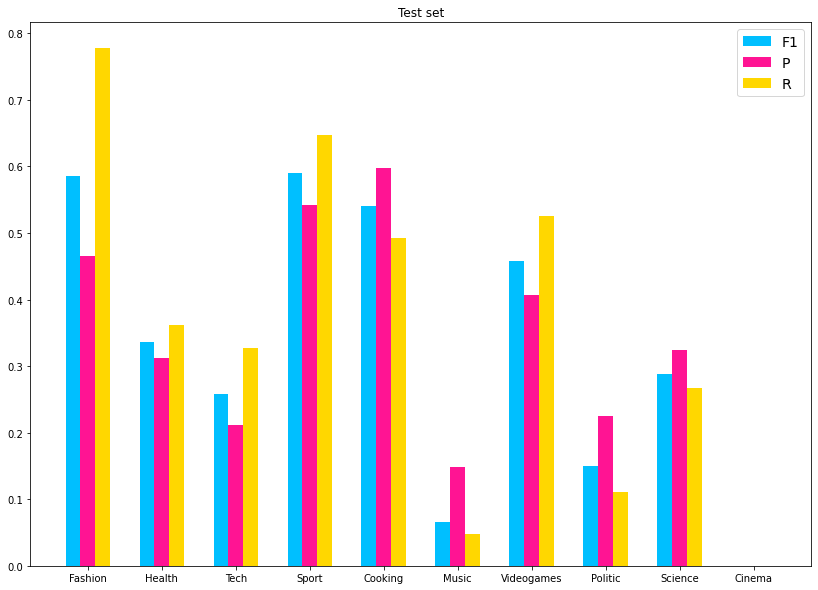

In [18]:
e=len(history.epoch)-11
labels = ['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
barWidth = 0.2
F1=[history.history['val_Fashion_F1'][e], history.history['val_Health_F1'][e], history.history['val_Tech_F1'][e], history.history['val_Sport_F1'][e], history.history['val_Cooking_F1'][e], history.history['val_Music_F1'][e], history.history['val_Videogames_F1'][e], history.history['val_Politic_F1'][e], history.history['val_Science_F1'][e], history.history['val_Cinema_F1'][e]]
P=[history.history['val_Fashion_P'][e], history.history['val_Health_P'][e], history.history['val_Tech_P'][e], history.history['val_Sport_P'][e], history.history['val_Cooking_P'][e], history.history['val_Music_P'][e], history.history['val_Videogames_P'][e], history.history['val_Politic_P'][e], history.history['val_Science_P'][e], history.history['val_Cinema_P'][e]]
R=[history.history['val_Fashion_R'][e], history.history['val_Health_R'][e], history.history['val_Tech_R'][e], history.history['val_Sport_R'][e], history.history['val_Cooking_R'][e], history.history['val_Music_R'][e], history.history['val_Videogames_R'][e], history.history['val_Politic_R'][e], history.history['val_Science_R'][e], history.history['val_Cinema_R'][e]]
r1 = range(len(F1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

plt.figure(figsize=(14, 10))
plt.bar(r1, F1, width = barWidth, color = ['deepskyblue' for i in F1], linewidth = 2, label='F1')
plt.bar(r2, P, width = barWidth, color = ['deeppink' for i in R], linewidth = 4, label='P')
plt.bar(r3, R, width = barWidth, color = ['gold' for i in P], linewidth = 6, label='R')
plt.legend(fontsize=14)
plt.xticks([r + barWidth  for r in range(len(F1))], labels)
plt.title('Test set')

#### <font color=black> Affichage du nombre d'image dans chaque catégorie</font>

In [93]:
f=0
h=0
t=0
sp=0
co=0
m=0
v=0
p=0
sc=0
ci=0
dirs = os.listdir( "Images/" )
for file in dirs:
    if (file.find('Fashion')!=-1):
        f+=1
    if (file.find('Health')!=-1):
        h+=1
    if (file.find('Tech')!=-1):
        t+=1
    if (file.find('Sport')!=-1):
        sp+=1
    if (file.find('Cooking')!=-1):
        co+=1
    if (file.find('Music')!=-1):
        m+=1
    if (file.find('Videogames')!=-1):
        v+=1
    if (file.find('Politic')!=-1):
        p+=1
    if (file.find('Science')!=-1):
        sc+=1
    if (file.find('Cinema')!=-1):
        ci+=1
print('Fasion=', f)
print('Health=', h)
print('Tech=', t)
print('Sport=', sp)
print('Cooking=', co)
print('Music=', m)
print('Videogames=', v)
print('Politic=', p)
print('Science=', sc)
print('Cinema=', ci)

print(f+h+t+sp+co+m+v+p+sc+ci)

Fasion= 1478
Health= 812
Tech= 643
Sport= 1240
Cooking= 639
Music= 814
Videogames= 943
Politic= 824
Science= 820
Cinema= 673
8886
